# SIMD
## 1) Trace of Matrix Product
### a)

In [23]:
function tracemul(a::AbstractMatrix, b::AbstractMatrix)
    if size(a, 2) != size(b, 1)
        error("Matrix multiplication is not defined for these matrices")
    elseif size(a, 1) != size(b, 2)
        error("The product is not a square matrix; trace is only defined for square matrices")
    end
    traceval = zero(eltype(a)) * zero(eltype(b)) # getting zero with the correct element type
    for i in 1:size(a, 1)
        for j in 1:size(a, 2)
            @inbounds traceval += a[i, j] * b[j, i]
        end
    end
    return traceval
end

tracemul (generic function with 1 method)

In [24]:
function tracemul_simd(a::AbstractMatrix, b::AbstractMatrix)
    if size(a, 2) != size(b, 1)
        error("Matrix multiplication is not defined for these matrices")
    elseif size(a, 1) != size(b, 2)
        error("The product is not a square matrix; trace is only defined for square matrices")
    end
    traceval = zero(eltype(a)) * zero(eltype(b)) # getting zero with the correct element type
    @simd for i in 1:size(a, 1)
        @simd for j in 1:size(a, 2)
            @inbounds traceval += a[i, j] * b[j, i]
        end
    end
    return traceval
end

tracemul_simd (generic function with 1 method)

In [25]:
using LinearAlgebra
a = rand(100, 100)
b = rand(100, 100)
tracemul_simd(a, b) ≈ tr(a * b)

true

In [26]:
using BenchmarkTools
matrixsize = 100
@benchmark tracemul(a, b) setup=(a = rand($matrixsize, $matrixsize); b = rand($matrixsize, $matrixsize))

BenchmarkTools.Trial: 10000 samples with 4 evaluations.
 Range (min … max):  7.025 μs …  16.975 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     7.225 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.367 μs ± 486.549 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▄██▆▆▄▃▅▃▆▅▅▃▂▂▁ ▁ ▁                 ▁                     ▂
  ▆█████████████████████▇▇▅▇▇▆▇▆▆█▆▆▄▅▇▇█▆▅▄▅▃▄▅▆▅▄▄▅▄▅▄▁▁▃▇▇ █
  7.02 μs      Histogram: log(frequency) by time      9.68 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [27]:
@benchmark tracemul_simd(a, b) setup=(a = rand($matrixsize, $matrixsize); b = rand($matrixsize, $matrixsize))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   9.500 μs … 36.400 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):      9.800 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.115 μs ±  1.097 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▇█▆▅ ▅▇▅ ▅▄▄ ▄▃▃ ▃▂▂▂ ▂▂▂ ▁▁▁   ▁ ▁                         ▂
  ████▁███▁███▁███▁████▁███▁███▁███▁██▇▁▇▇▆▆▁▅▅▇▁▆▆▆▁▅▅▄▁▆▅▄▅ █
  9.5 μs       Histogram: log(frequency) by time        14 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [28]:
@benchmark tr(a*b) setup=(a = rand($matrixsize, $matrixsize); b = rand($matrixsize, $matrixsize))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   84.800 μs …  3.232 ms  ┊ GC (min … max): 0.00% … 95.08%
 Time  (median):     104.850 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   109.872 μs ± 64.575 μs  ┊ GC (mean ± σ):  2.11% ±  3.75%

    ▂██▆▄▁            ▁                                         
  ▁▅███████▇▆▆▆▅▅▅▆▇▇██▇▇▇▆▆▆▅▅▄▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁ ▃
  84.8 μs         Histogram: frequency by time          163 μs <

 Memory estimate: 78.17 KiB, allocs estimate: 2.

Using SIMD seems to slow down the computation. This is probably because the compiler can optimize the function better than SIMD instructions (maybe something similar to BLAS).
The function is faster than simply multiplying and taking the trace with `LinearAlgebra` nontheless.

### b)
Since the indices never go out of bounds, `@inbounds` is used.

### c)

In [12]:
using BenchmarkTools, DataFrames, CSV
simdtime, latime = Float64[], Float64[]
for n in 2:100
    simdbench = @benchmark tracemul_simd(a, b) setup=(a=rand($n, $n); b=rand($n, $n))
    labench = @benchmark tr(a*b) setup=(a = rand($n, $n); b = rand($n, $n))
    push!(simdtime, mean(simdbench).time)
    push!(latime, mean(labench).time)
end
CSV.write("tracemul_benchmark.csv", DataFrame(
    "Matrix Size" => 2:100,
    "SIMD" => simdtime,
    "LinearAlgebra" => latime))

"tracemul_benchmark.csv"

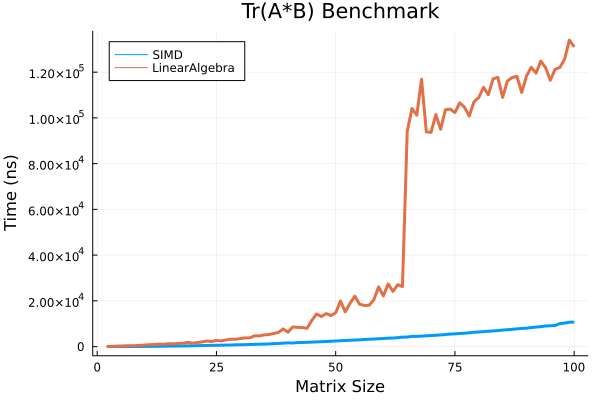

In [ ]:
using DataFrames, CSV, Plots
df = CSV.read("tracemul_benchmark.csv", DataFrame)
plot(df."Matrix Size", [df."SIMD" df."LinearAlgebra"], xlabel="Matrix Size", ylabel="Time (ns)",
    labels=["SIMD" "LinearAlgebra"], lw=3, title="Tr(A*B) Benchmark", legend=:topleft)

# Multithreading
## 2) Matrix Multiplication

In [32]:
function matmul_sequential(a::AbstractMatrix, b::AbstractMatrix)
    if size(a, 2) != size(b, 1)
        error("Matrix multiplication is not defined for these matrices")
    end
    c = zeros(eltype(a), size(a, 1), size(b, 2))
    for j in 1:size(b, 2)
        for i in 1:size(a, 1)
            for k in 1:size(a, 2)
                @inbounds c[i, j] += a[i, k] * b[k, j]
            end
        end
    end
    return c
end

matmul_sequential (generic function with 1 method)

In [33]:
function matmul_threaded(a::AbstractMatrix, b::AbstractMatrix)
    if size(a, 2) != size(b, 1)
        error("Matrix multiplication is not defined for these matrices")
    end
    c = zeros(eltype(a), size(a, 1), size(b, 2))
    Threads.@threads for j in 1:size(b, 2)
        for i in 1:size(a, 1)
            for k in 1:size(a, 2)
                @inbounds c[i, j] += a[i, k] * b[k, j]
            end
        end
    end
    return c
end

matmul_threaded (generic function with 1 method)

In [34]:
using BenchmarkTools
matrixsize = 100
@benchmark matmul_sequential(a, b) setup=(a = rand($matrixsize, $matrixsize); b = rand($matrixsize, $matrixsize))

BenchmarkTools.Trial: 7946 samples with 1 evaluation.
 Range (min … max):  544.800 μs …  3.981 ms  ┊ GC (min … max): 0.00% … 83.96%
 Time  (median):     583.000 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   591.567 μs ± 86.144 μs  ┊ GC (mean ± σ):  0.52% ±  3.00%

                   ▂█▃                                          
  ▁▁▁▂▂▁▁▁▁▂▂▃▃▂▂▃████▇▅▄▄▅▆▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  545 μs          Histogram: frequency by time          653 μs <

 Memory estimate: 78.17 KiB, allocs estimate: 2.

In [35]:
@benchmark matmul_threaded(a, b) setup=(a = rand($matrixsize, $matrixsize); b = rand($matrixsize, $matrixsize))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   94.500 μs …   4.254 ms  ┊ GC (min … max): 0.00% … 93.06%
 Time  (median):     142.400 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   151.255 μs ± 116.364 μs  ┊ GC (mean ± σ):  3.76% ±  5.16%

   ▆█▁                                                           
  ▄███▆▅▅▇█▇▆▆▅▅▄▄▄▃▄▄▄▄▅▆▅▆▇▆██▆▆▆▅▅▅▄▃▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  94.5 μs          Histogram: frequency by time          255 μs <

 Memory estimate: 83.02 KiB, allocs estimate: 42.

In [36]:
@benchmark a*b setup=(a = rand($matrixsize, $matrixsize); b = rand($matrixsize, $matrixsize))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   79.900 μs …  4.000 ms  ┊ GC (min … max): 0.00% … 95.86%
 Time  (median):     103.600 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   110.973 μs ± 75.642 μs  ┊ GC (mean ± σ):  2.46% ±  3.78%

    ▁▇█▅▃▃▂▂▂▁▁▁▁                                               
  ▁▄██████████████▇▆▆▅▅▅▄▄▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  79.9 μs         Histogram: frequency by time          217 μs <

 Memory estimate: 78.17 KiB, allocs estimate: 2.

In [38]:
using BenchmarkTools, DataFrames, CSV
threaded_time, builtin_time = Float64[], Float64[]
for n in 2:100
    threaded_bench = @benchmark matmul_threaded(a, b) setup=(a = rand($n, $n); b = rand($n, $n))
    builtin_bench = @benchmark a*b setup=(a = rand($n, $n); b = rand($n, $n))
    push!(threaded_time, mean(threaded_bench).time)
    push!(builtin_time, mean(builtin_bench).time)
end
CSV.write("matmul_benchmark.csv", DataFrame(
    "Matrix Size" => 2:100,
    "Multithreaded" => threaded_time,
    "Built-in" => builtin_time))

"matmul_benchmark.csv"

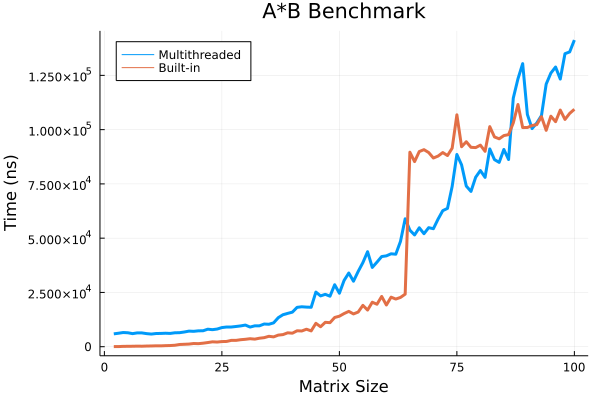

In [ ]:
using DataFrames, CSV, Plots
df = CSV.read("matmul_benchmark.csv", DataFrame)
plot(df."Matrix Size", [df."Multithreaded" df."Built-in"], xlabel="Matrix Size", ylabel="Time (ns)",
    labels=["Multithreaded" "Built-in"], lw=3, title="A*B Benchmark", legend=:topleft)

## 3) Monte Carlo Area Calculation

In [1]:
function mcarea(n::Integer)
    threadcount = zeros(Int, Threads.nthreads())
    Threads.@threads for _ in 1:n
        x, y = rand(2)
        xsq, ysq, onexsq, oneysq = x^2, y^2, (1 - x)^2, (1 - y)^2
        @inbounds threadcount[Threads.threadid()] += (
            xsq + ysq < 1 && xsq + oneysq < 1 && onexsq + ysq < 1 && onexsq + oneysq < 1)
    end
    fullcount = 0
    # sum the partial results from each thread
    for i in eachindex(threadcount)
        @inbounds fullcount += threadcount[i]
    end
    return fullcount / n
end

mcarea (generic function with 1 method)

In [8]:
@time mcarea(1_000_000_000)

 38.315298 seconds (1.00 G allocations: 74.506 GiB, 40.91% gc time)


0.315151264

# Distributed Computing
## 4) Buffon's Needle Problem

In [40]:
using Distributed

@everywhere function buffon_single(lengthratio::Real, linecount::Integer)
    x = (linecount - 1) * rand()
    dist = min(x % 1, 1 - (x % 1)) # distance from the closest line
    θ = π * (rand() - 0.5)
    return dist < lengthratio / 2 * cos(θ)
end

function buffon_distributed(lengthratio::Real, linecount::Integer,
        steps::Integer, batch::Integer = 10000)
    intersect_count = @distributed (+) for i in 1:round(Int, steps/batch)
        sum(buffon_single(lengthratio, linecount) for j in 1:batch)
    end
    return intersect_count / (round(Int, steps/batch) * batch)
end

function buffon_serial(lengthratio::Real, linecount::Integer, steps::Integer)
    return sum(buffon_single(lengthratio, linecount) for j in 1:steps) / steps
end

buffon_serial (generic function with 1 method)

In [10]:
addprocs(7)
nprocs()

8

In [54]:
ratio = 0.5
buffon_value = buffon_distributed(ratio, 10, 1_000_000_000)
buffon_pi = 2 * ratio / buffon_value

3.1414305851214785

In [55]:
abs(buffon_pi - π)

0.000162068468314569

In [51]:
@time buffon_serial(ratio, 10, 1_000_000_000)

 25.374140 seconds (1 allocation: 16 bytes)


0.318309869

In [53]:
@time buffon_distributed(ratio, 10, 1_000_000_000)

  4.447744 seconds (544 allocations: 23.734 KiB)


0.318332712

# Static Arrays
## 5) The StaticArrays Package
### a)
`SArray`s are used to speed up computations with completely immutable arrays (constant size AND constant elements). This is achieved through stack-allocation (instead of the default heap-allocation for built-in Julia arrays).

`MArray`s are used to speed up computations with constant size, but nonconstant elements. The speed-up achieved here is due to compiler optimization (these arrays are heap-allocated)

### b)

In [1]:
using StaticArrays, BenchmarkTools, DataFrames, CSV
static_time, builtin_time = Float64[], Float64[]
for n in 2:35
    static_bench = @benchmark a*b setup=(a = @SArray rand($n, $n); b = @SArray rand($n, $n))
    builtin_bench = @benchmark a*b setup=(a = rand($n, $n); b = rand($n, $n))
    push!(static_time, mean(static_bench).time)
    push!(builtin_time, mean(builtin_bench).time)
end
CSV.write("staticarrays_benchmark.csv", DataFrame(
    "Matrix Size" => 2:35,
    "StaticArrays" => static_time,
    "Built-in" => builtin_time))

"staticarrays_benchmark.csv"

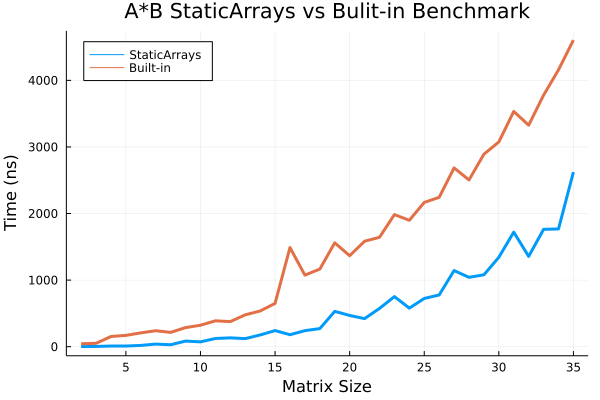

In [3]:
using DataFrames, CSV, Plots
df = CSV.read("staticarrays_benchmark.csv", DataFrame)
plot(df."Matrix Size", [df."StaticArrays" df."Built-in"], xlabel="Matrix Size", ylabel="Time (ns)",
    labels=["StaticArrays" "Built-in"], lw=3, title="A*B StaticArrays vs Bulit-in Benchmark", legend=:topleft)